# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], 
                                      #                     [0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406],
                                     #                     [0.229, 0.224, 0.225])
                                    ])

In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


Num training images:  4996
Num test images:  1250


In [4]:
f = glob.glob(train_dir+'*')
classes = np.array([landmark.split('.')[-1] for landmark in f])

In [5]:
print(classes)

['Haleakala_National_Park' 'Mount_Rainier_National_Park'
 'Ljubljana_Castle' 'Dead_Sea' 'Wroclaws_Dwarves' 'London_Olympic_Stadium'
 'Niagara_Falls' 'Stonehenge' 'Grand_Canyon' 'Golden_Gate_Bridge'
 'Edinburgh_Castle' 'Mount_Rushmore_National_Memorial' 'Kantanagar_Temple'
 'Yellowstone_National_Park' 'Terminal_Tower' 'Central_Park'
 'Eiffel_Tower' 'Changdeokgung' 'Delicate_Arch' 'Vienna_City_Hall'
 'Matterhorn' 'Taj_Mahal' 'Moscow_Raceway' 'Externsteine' 'Soreq_Cave'
 'Banff_National_Park' 'Pont_du_Gard' 'Seattle_Japanese_Garden'
 'Sydney_Harbour_Bridge' 'Petronas_Towers' 'Brooklyn_Bridge'
 'Washington_Monument' 'Hanging_Temple' 'Sydney_Opera_House'
 'Great_Barrier_Reef' 'Monumento_a_la_Revolucion' 'Badlands_National_Park'
 'Atomium' 'Forth_Bridge' 'Gateway_of_India' 'Stockholm_City_Hall'
 'Machu_Picchu' 'Death_Valley_National_Park' 'Gullfoss_Falls'
 'Trevi_Fountain' 'Temple_of_Heaven' 'Great_Wall_of_China'
 'Prague_Astronomical_Clock' 'Whitby_Abbey' 'Temple_of_Olympian_Zeus']


In [6]:
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- I simply resized the image to (224, 224), which is required as the input of most imageNet based models. 
- Augmentation was not applied here. But below in the transfer learning, an image augmentation was applied(flips and color adjustment).

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

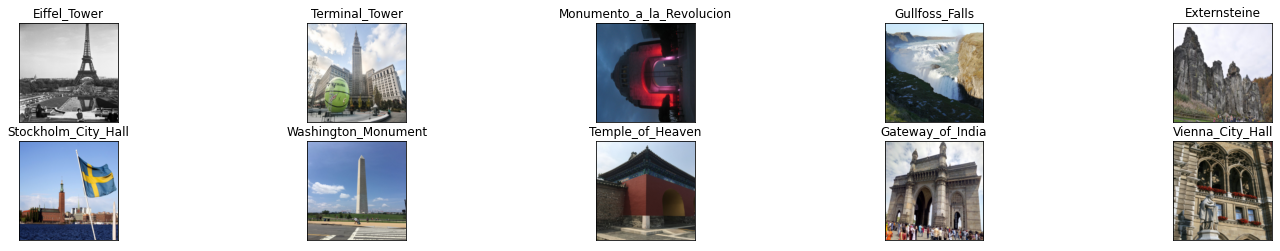

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [8]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [9]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [10]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)  
        self.l1 = nn.Linear(6400, 4096)
        self.l2 = nn.Linear(4096, 4096)
        self.l3 = nn.Linear(4096, 50)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        
        self.Sequential = (self.conv1, nn.ReLU(), self.maxpool,
                           self.conv2, nn.ReLU(), self.maxpool,
                           self.conv3, nn.ReLU(),
                           self.conv4, nn.ReLU(),
                           self.conv5, nn.ReLU(), self.maxpool, nn.Flatten(),
                           self.l1, nn.ReLU(), self.dropout,
                           #self.l2, nn.ReLU(), self.dropout,
                           self.l3
                          )

    def forward(self, x):
        ## Define forward behavior
        for layer in self.Sequential:
            x = layer(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

- This is simply an architecture copied from __AlexNet__, with slight adjustments, as you can see. Since I wanted to test if those classic architectures are helpful.
- These convolutional layers are from AlexNet, each followed by a ReLU for non-linearity. The first, second and last convolutional layers are also followed by a maxpooling layer for smoothing.
- Need to notice that the final 3 large dense layers in AlexNet didn't perform well in training below. As a result I removed the second dense layer.
- Generally I wanted to test if those classic architectures are helpful. As can be shown below that it didn't perform well and overfitting was witnessed, maybe beacause AlexNet architecture is still far more complicated considering the small dataset we are dealing with here.

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [12]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)    
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

D:\Users\BlickWinkel\Anaconda3\envs\d2l\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 3.968282 	Validation Loss: 3.913255
Validation loss decreased (inf --> 3.913255).  Saving model ...
Epoch: 2 	Training Loss: 3.899166 	Validation Loss: 3.845753
Validation loss decreased (3.913255 --> 3.845753).  Saving model ...
Epoch: 3 	Training Loss: 3.901800 	Validation Loss: 3.843486
Validation loss decreased (3.845753 --> 3.843486).  Saving model ...
Epoch: 4 	Training Loss: 3.783541 	Validation Loss: 3.668252
Validation loss decreased (3.843486 --> 3.668252).  Saving model ...
Epoch: 5 	Training Loss: 3.636064 	Validation Loss: 3.581592
Validation loss decreased (3.668252 --> 3.581592).  Saving model ...
Epoch: 6 	Training Loss: 3.546321 	Validation Loss: 3.552868
Validation loss decreased (3.581592 --> 3.552868).  Saving model ...
Epoch: 7 	Training Loss: 3.432930 	Validation Loss: 3.467502
Validation loss decreased (3.552868 --> 3.467502).  Saving model ...
Epoch: 8 	Training Loss: 3.360563 	Validation Loss: 3.424954
Validation loss decreased (3.46750

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [13]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.941792 	Validation Loss: 3.912816
Validation loss decreased (inf --> 3.912816).  Saving model ...
Epoch: 2 	Training Loss: 3.942456 	Validation Loss: 3.910499
Validation loss decreased (3.912816 --> 3.910499).  Saving model ...
Epoch: 3 	Training Loss: 3.911488 	Validation Loss: 3.907923
Validation loss decreased (3.910499 --> 3.907923).  Saving model ...
Epoch: 4 	Training Loss: 3.910934 	Validation Loss: 3.905292
Validation loss decreased (3.907923 --> 3.905292).  Saving model ...
Epoch: 5 	Training Loss: 3.896383 	Validation Loss: 3.895280
Validation loss decreased (3.905292 --> 3.895280).  Saving model ...
Epoch: 6 	Training Loss: 3.851149 	Validation Loss: 3.774272
Validation loss decreased (3.895280 --> 3.774272).  Saving model ...
Epoch: 7 	Training Loss: 3.776986 	Validation Loss: 3.700863
Validation loss decreased (3.774272 --> 3.700863).  Saving model ...
Epoch: 8 	Training Loss: 3.649232 	Validation Loss: 3.631127
Validation loss decreased (3.70086

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.136804


Test Accuracy: 23% (292/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
                                      ])

test_transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
                                    ])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Num training images:  4996
Num test images:  1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [16]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model, is_pretrained=True):
    ## TODO: select and return an optimizer
    if is_pretrained:
        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture

model_transfer = models.resnext50_32x4d(pretrained=True)

for name, param in model_transfer.named_parameters():
    if name not in {'fc.weight', 'fc.bias'}:
        param.requires_grad = False

model_transfer.fc = nn.Linear(2048, 50)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

- I inspected models available in https://pytorch.org/vision/stable/models.html. I knew that ResNet series serve as great pre-trained model for transfer learning, then I noticed that ResNeXt is an improved version of ResNet. So I decided to try this model.
- ResNeXt is also trained on ImageNet, while our dataset is somehow similar to a subset of classes in ImageNet. 
- Also considering that the dataset is relatively small, it should be reasonable to freeze all layers but the last fully-connected one in ResNeXt.
- For the last fc layer, I replaced it with nn.Linear(2048, 50) to fit our dataset. Only parameters in this layer will be updated through backpropagation. 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [18]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

num_epochs = 5

# train the model
model_scratch = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.092070 	Validation Loss: 2.248145
Validation loss decreased (inf --> 2.248145).  Saving model ...
Epoch: 2 	Training Loss: 1.829723 	Validation Loss: 1.655475
Validation loss decreased (2.248145 --> 1.655475).  Saving model ...
Epoch: 3 	Training Loss: 1.361910 	Validation Loss: 1.423723
Validation loss decreased (1.655475 --> 1.423723).  Saving model ...
Epoch: 4 	Training Loss: 1.123937 	Validation Loss: 1.316438
Validation loss decreased (1.423723 --> 1.316438).  Saving model ...
Epoch: 5 	Training Loss: 1.002515 	Validation Loss: 1.303542
Validation loss decreased (1.316438 --> 1.303542).  Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.055355


Test Accuracy: 74% (928/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [22]:
transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.ToTensor()]
                              )

In [31]:
import cv2
from PIL import Image
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

model_transfer.eval()

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = test_transform(Image.open(img_path))
    img = img.reshape(1, *img.shape)
    img = img.cuda()
    pred = model_transfer(img)
    indices = torch.topk(pred, k)[1].to('cpu').tolist()
    return classes[tuple(indices)]

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

array(['Golden_Gate_Bridge', 'Forth_Bridge', 'Brooklyn_Bridge',
       'Sydney_Harbour_Bridge', 'Pont_du_Gard'], dtype='<U32')

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the 
Golden_Gate_Bridge, Forth_Bridge, or Brooklyn_Bridge?


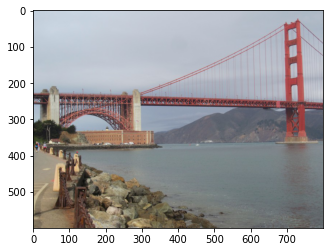

In [32]:
def suggest_locations(img_path):
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)    
    print("Is this picture of the \n{}, {}, or {}?".format(predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2]))
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Generally better than my expectation. As we can see that there are a lot of noises in both training and test sets. For example, there are some images in which only tourists are visible, some images in which a really small part of the landmark is present, and some images presented in the wrong layout.

(Three possible points for improvement)
- Noises should be reduced. For example, images with only tourists should be erased and layouts of some images should be adjusted, which requires much efforts.
- Different models besides resnext50 and different structures of the final dense layers can be explored.
- Hyperparameter tuning was not implemented. 
    - A default initialization was applied here. Other initializations like Xavier or Kaiming normalization can be tried.
    - I only ran 5 epoches here. More epoches might lead to lower loss. 
    - However, noticing that the dataset is relatively small, exhaustic hyperparameter tuning can lead to overfitting.

Is this picture of the 
Eiffel_Tower, Sydney_Harbour_Bridge, or Pont_du_Gard?


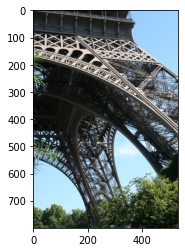

In [33]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/test/16.Eiffel_Tower/3828627c8730f160.jpg')

Is this picture of the 
Machu_Picchu, Great_Wall_of_China, or Death_Valley_National_Park?


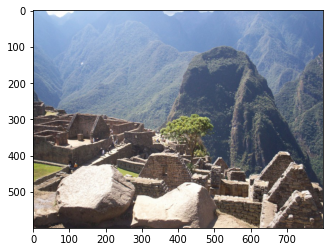

In [34]:
suggest_locations('images/test/41.Machu_Picchu/4336abf3179202f2.jpg') 

Is this picture of the 
Edinburgh_Castle, Machu_Picchu, or Great_Wall_of_China?


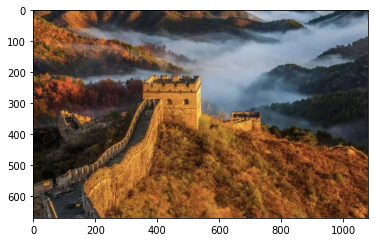

In [36]:
suggest_locations('images/The_Great_Wall.jpeg') # Correct, but not the highest prediction

Is this picture of the 
Great_Wall_of_China, Edinburgh_Castle, or Whitby_Abbey?


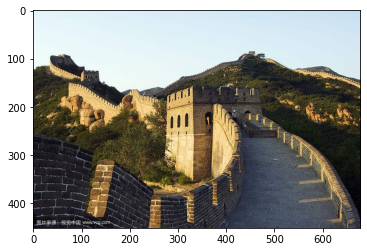

In [38]:
suggest_locations('images/GW1.jpg') # Correct

Kinkaku-ji is actually __not present__ in the training set.

The model predicts Central_Park and Seattle_Japanese_Garden perhaps based on the green surroundings.

Is this picture of the 
Seattle_Japanese_Garden, Central_Park, or Taj_Mahal?


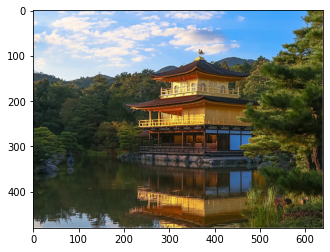

In [40]:
suggest_locations('images/Kinkakuji.jpg') #Kinkaku-ji 